In [1]:
import pandas as pd 
import numpy as np
import json
import requests
import os 
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta
import urllib
import datetime

import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import spacy
nlp = spacy.load("ja_core_news_lg")

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
import colorgram
import calmap

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis



from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.palettes import Category20b, cividis, inferno
from bokeh.plotting import figure
from bokeh.transform import factor_cmap, cumsum
from bokeh.layouts import column
from math import pi

## Helper functions -- data

In [2]:
# encode japanese word (search term) for url so that it works with the retrieving
def encode_japanese(japanese_word):
    return urllib.parse.quote(japanese_word)

In [3]:
# for example
encode_japanese("東京")

'%E6%9D%B1%E4%BA%AC'

In [4]:
# get date in the format required for api 
def datetime_conversion(date):     
    year = str(date.year)   
    if len(str(date.month)) == 2:
        month = str(date.month)
    else:
        month = "0" + str(date.month)
    if len(str(date.day)) == 2:
        day = str(date.day)
    else:
        day = "0" + str(date.day)
    
    return (year + month + day)

## Helper functions -- other

###  Graphs

In [5]:
def barchart(counted_data, counts, output_here=True, 
             save_filename="plot", plot_height=350, plot_width=800, title="Title", bgcolor = "#2b2b2b"):
    # either display in the notebook or save file 
    if output_here:
        output_notebook()
    else:
        output_file(save_filename+".html")
            
    source = ColumnDataSource(data=dict(counted_data=counted_data, counts=counts))
    p = figure(x_range=counted_data, plot_height=plot_height, plot_width=plot_width, toolbar_location=None, title=title)
    
    p.vbar(x='counted_data',
           top='counts', 
           width=0.8, 
           source=source, 
           line_color='white', 
           fill_color=factor_cmap('counted_data', palette=cividis(len(counted_data)), factors=counted_data))
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.major_label_orientation = 1.2
    p.background_fill_color = bgcolor
    
    show(p)

In [6]:
def piechart(df, df_items_col, df_values_col, title="Title", plot_height=350, plot_width=350):
    output_notebook()
    # create columns for the angle for each slice and its colour
    df['angle'] = df[df_values_col] / df[df_values_col].sum() * 2*pi
    df['color'] = cividis(len(df))
    
    p = figure(plot_height=plot_height, plot_width=plot_width, title=title, toolbar_location=None,
           tools="hover", tooltips="@{}: @{}".format(df_items_col, df_values_col), x_range=(-0.5, 1.0))
    p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field=df_items_col, source=df)

    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None

    show(p)

In [7]:
def line_range(dates, data, start_date_number=0, end_date_number=30, label="Label", line_colour="maroon"):
    source = ColumnDataSource(data=dict(date=dates, data=data))
    
    p = figure(plot_height=300, plot_width=1000, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[start_date_number], dates[end_date_number]))
    
    p.line('date', 'data', source=source, color=line_colour, line_width=2)
    p.yaxis.axis_label = label
    
    select = figure(title="Drag slider",
                plot_height=130, plot_width=1000, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, 
                background_fill_color= "#2b2b2b")
                #background_fill_color="#efefef")
    
    range_tool = RangeTool(x_range=p.x_range)
    range_tool.overlay.fill_color = "white"
    range_tool.overlay.fill_alpha = 0.2
    
    select.line('date', 'data', source=source)
    select.ygrid.grid_line_color = None
    select.add_tools(range_tool)
    select.toolbar.active_multi = range_tool
    
    show(column(p, select))

## Query functions

### query by word/seach term 

In [8]:
def query_by_word(word):
    url = 'http://agora.ex.nii.ac.jp/cgi-bin/crisis-api/word.pl?key=' + encode_japanese(word)
    req = urllib.request.Request(url)

    r = urllib.request.urlopen(req).read()
    cont = json.loads(r.decode('utf-8'))
    result = cont['response']['results']
    return result 

In [9]:
# example 
result = query_by_word("東大")

### query by single date 

In [10]:
# in the format YYYYMMDD
def query_by_date(date):
    url = 'http://agora.ex.nii.ac.jp/cgi-bin/crisis-api/date.pl?date=' + date
    req = urllib.request.Request(url)

    r = urllib.request.urlopen(req).read()
    cont = json.loads(r.decode('utf-8'))
    result = cont['response']['results']
    return result 

In [11]:
result = query_by_date("20200110")

### query by date range 

In [12]:
def query_by_date_range(start_date, end_date):
    delta = datetime.timedelta(days=1)
    results = []
    while start_date <= end_date:       
        date_formatted = datetime_conversion(start_date)
        result_for_date = query_by_date(date_formatted)
        results.extend(result_for_date)
        start_date += delta
    return results

In [13]:
start_date = datetime.date(2020, 10, 1)
end_date = datetime.date(2020, 10, 2)
result = query_by_date_range(start_date, end_date)

### data by keyword

- Try searching by different ways of saying covid19,
- Unite into a single df and drop repated entries

In [14]:
result_shingatacorona = query_by_word("新型コロナウイルス")

# Read in data 

### all news 

In [15]:
data_path = "../Data/japanese_news/"

In [16]:
df = pd.read_csv(data_path + "df_yahoo_nov14.csv", index_col=0)

### asahi news 
- including translations 

# Data Exploration 

In [17]:
df_asahi = pd.read_csv(data_path + "df_asahi_nov14.csv", index_col=0)

In [18]:
df_asahi.head(2)

,date,title,source,translation
id,,,,
20200222-00000016-sasahi-soci,2020-02-22 17:35:00,「感染者の巣窟のように…」病院、タクシーで風評被害が拡大〈週刊朝日〉,週刊朝日,'Like an infected person's den ...' Hospitals ...
20200225-00000068-sasahi-soci,2020-02-25 19:35:00,株価急落に初の倒産 政府対応遅れがコロナショックを深刻化〈週刊朝日〉,週刊朝日,First bankruptcy due to stock price plunge Del...


### Extract datetime features

In [19]:
def get_time_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year 
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.weekday
    df['date'] = pd.to_datetime(df['date'].apply(lambda x : str(x).split(" ")[0]))
    return df

In [20]:
df = get_time_features(df)

### Sources 
Which are the unique sources and how frequent each of them is 

In [21]:
sources_df = pd.DataFrame(df['source'].value_counts()).reset_index()
sources_df.columns = ['source', 'count']

In [22]:
len(sources_df)

628

In [23]:
sources_df_reduced = sources_df.iloc[:100].append(
    pd.DataFrame([["other", sources_df.iloc[100:]['count'].sum()]], columns=['source', 'count'])).sort_values(by="count", ascending=False)

In [24]:
piechart(sources_df.iloc[:20], "source", "count", title="Top 20 highest represented sources", plot_height=550, plot_width=700)

Loading BokehJS ...

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
piechart(sources_df_reduced, "source", "count", title="Top 100 sources and others", plot_height=800, plot_width=900)

Loading BokehJS ...

### Treds over time 

In [26]:
articles_by_date_df = pd.DataFrame(df.groupby("date")['title'].count()).reset_index()

In [27]:
dates = np.array(articles_by_date_df['date'], dtype=np.datetime64)
data = np.array(articles_by_date_df['title'])

In [28]:
line_range(dates, data, 0, 30, label="My Label", line_colour="deepskyblue")

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd54fba8910>],
       dtype=object))

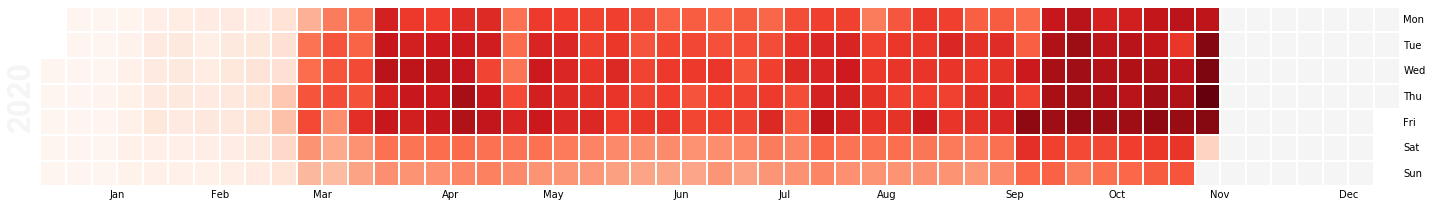

In [29]:
porg = df.groupby("date")['title'].count()
calmap.calendarplot(porg, fig_kws=dict(figsize=(20, 20)))

### just for Asahi 

In [30]:
articles_by_date_asahi_df = pd.DataFrame(df.dropna()[df.dropna()['source'].str.contains("朝日")].groupby("date")['title'].count()).reset_index()

In [31]:
dates_asahi = np.array(articles_by_date_asahi_df['date'], dtype=np.datetime64)
data_asahi = np.array(articles_by_date_asahi_df['title'])

In [32]:
line_range(dates_asahi, data_asahi, 0, 30, label="My Label", line_colour="deepskyblue")

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/Users/dea/opt/anaconda3/lib/python3.7/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


In [33]:
porg = df.dropna()[df.dropna()['source'].str.contains("朝日")].groupby("date")['title'].count()

(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd54e5853d0>],
       dtype=object))

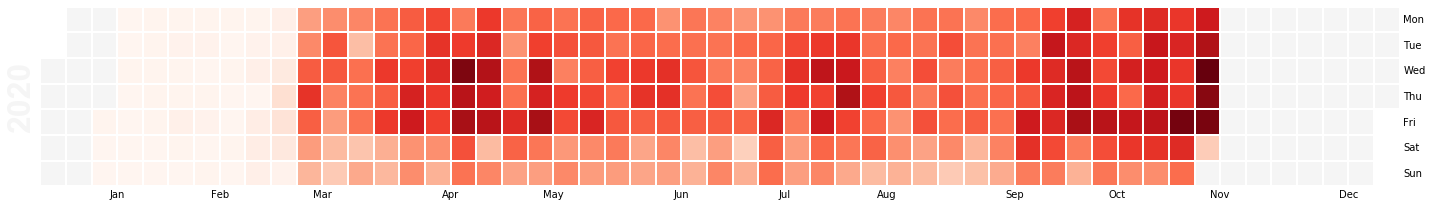

In [34]:
calmap.calendarplot(porg, fig_kws=dict(figsize=(20, 20)))

## Text cleaning and pre-processing

In [35]:
# Spacy: Takes in a document, returns the list of words
def tokenize_jp_spacy(text, remove_stopwords=True):
    if remove_stopwords: 
        doc = nlp((text))
    else:
        doc = nlp(text)
    tokens = [token.text for token in doc if token.is_stop==False]    
    return tokens

### Text -> bag of words

In [36]:
def remove_numbers(text):
    to_remove = "０１２３４５６７８９" + "0123456789"
    pattern =  "["+ to_remove + "]"
    text = re.sub(pattern, "", text)
    return text

def remove_puctuation(text):
    to_remove = "“”。、！？ー・～〜~…...＠’" + ".,?!"
    pattern =  "["+ to_remove + "]"
    text = re.sub(pattern, "", text)
    return text

def remove_brackets(text):
    to_remove =  "「」＜＞「」［］『』（）〔〕｛｝｟｠〈〉《》【】〖〗〘〙〚〛(){} \[\]"
    pattern =  "["+ to_remove + "]"
    text = re.sub(pattern, "", text)
    return text

def remove_other(text):
    to_remove =  "％＆&－／：/:＋＝＃〜｜\+\-\"\'±"
    pattern =  "["+ to_remove + "]"
    text = re.sub(pattern, "", text)
    return text

<>:14: DeprecationWarning: invalid escape sequence \[
<>:20: DeprecationWarning: invalid escape sequence \+
<>:14: DeprecationWarning: invalid escape sequence \[
<>:20: DeprecationWarning: invalid escape sequence \+
<>:14: DeprecationWarning: invalid escape sequence \[
<>:20: DeprecationWarning: invalid escape sequence \+
<ipython-input-36-317330e69866>:14: DeprecationWarning: invalid escape sequence \[
  to_remove =  "「」＜＞「」［］『』（）〔〕｛｝｟｠〈〉《》【】〖〗〘〙〚〛(){} \[\]"
<ipython-input-36-317330e69866>:20: DeprecationWarning: invalid escape sequence \+
  to_remove =  "％＆&－／：/:＋＝＃〜｜\+\-\"\'±"


In [37]:
def text_to_bow_ja(text):

    if text == np.nan:
        return text 
    else: 
        # just in case there are non-Japanese words
        text = str(text).lower()
        # remove new lines and html remnants
        text = re.sub('\n', '', text) 
        text = re.sub('<br>', '', text) 
        
        # very simple link removal 
        text = re.sub(r"http\S+", "", text)
        text = re.sub("\u3000", '', text)
        
        text = remove_numbers(text)
        text = remove_puctuation(text)
        text = remove_brackets(text)
        text = remove_other(text)
        
        # remove multiple spaces
        text = re.sub(' +', '', text).strip()
        return text

### stopword removal

In [38]:
# Stop words removal with spacy but without lemmatizing 
def spacy_stopword_removal(text, nlp, language="ja"):
    doc = nlp((text))
    doc_tokens = []
    for token in doc:
        if token.is_stop == False:
            doc_tokens.append(token.text)
    if language == "en":
        lemmatized_text = " ".join(doc_tokens)
    elif language == 'ja':
        lemmatized_text = "".join(doc_tokens)
    return lemmatized_text

### lemmatisation 

In [39]:
# For a single string
def spacy_lemmatize_text(text):
    doc = nlp(text_to_bow(text))
    doc_tokens = []
    for token in doc:
        if token.is_stop == False:
            doc_tokens.append(token.lemma_)
    lemmatized_text = "".join(doc_tokens)
    return lemmatized_text

### --> Clean the text 

In [40]:
df.head()

,date,title,source,year,month,day,hour,weekday
id,,,,,,,,
20200101-00000001-binsider-int,2020-01-01,美しい太陽系の写真集…あなたが生まれた頃に撮影された写真も,BUSINESS INSIDER JAPAN,2020,1,1,8,2
20200101-00010003-macau-cn,2020-01-01,マカオ当局、空港での防疫対策強化…中国・武漢市で原因不明の肺炎患者連続発生受け,マカオ新聞,2020,1,1,20,2
20200102-00000071-kyodonews-int,2020-01-02,中国、肺炎騒ぎで8人処罰 「ネットでデマ」,共同通信,2020,1,2,21,3
20200103-00000074-kyodonews-soci,2020-01-03,中国、原因不明の肺炎44人に ウイルス特定続ける,共同通信,2020,1,3,21,4
20200103-00010000-cinemore-movi,2020-01-03,黒澤明監督版『東京オリンピック』はなぜ実現しなかったのか 後編,CINEMORE,2020,1,3,12,4


In [42]:
df = pd.read_csv("resources/jp_news_nov.csv", index_col=0)

In [43]:
# grab just the entries for Asahi 
df_asahi = df.dropna()[df.dropna()['source'].str.contains("朝日")]

## Bag of Words 

In [44]:
class BagOfWords:
    def __init__(self, data, max_df, min_df, stop_words, ngram_range, change_tokenizer=False, tokenizer=None) :
        self.data = data
        self.max_df = max_df 
        self.min_df = min_df 
        self.stop_words = stop_words 
        self.ngram_range = ngram_range 
        if change_tokenizer == True: 
            self.MyCountVectorizer = CountVectorizer(
                tokenizer=tokenizer,
                max_df=self.max_df, 
                min_df=self.min_df, 
                stop_words=self.stop_words, 
                ngram_range=self.ngram_range)
        else:   
            self.MyCountVectorizer = CountVectorizer(
                max_df=self.max_df, 
                min_df=self.min_df, 
                stop_words=self.stop_words, 
                ngram_range=self.ngram_range)
        # init the empty vars 
        self.X = ""
        self.feature_names = ""
        self.counts = ""
        self.df_counts = ""
        self.dict_counts = ""
        self.wordcloud = ""
        self.p = ""
        
    #fit the count vectorizer 
    def fit_transform(self):
        self.X = self.MyCountVectorizer.fit_transform(self.data)

    def get_feature_names(self):
        self.feature_names = self.MyCountVectorizer.get_feature_names()

    def get_bow_feature_counts(self): 
        self.counts = self.X.toarray().sum(axis=0)
        # create a df with feature names and counts 
        self.df_counts = pd.DataFrame({"feature_names": self.feature_names, "counts": self.counts}).sort_values(by="counts", ascending=False)

    # get the data into a dict format of {word: freq} type to feed into the wordcloud 
    def prep_for_wordcloud(self):
        _dict_counts = self.df_counts.set_index("feature_names").to_dict(orient="index")
        self.dict_counts = {}
        for keyword, count in _dict_counts.items():
            self.dict_counts[keyword] = count['counts']

    # visualise the word cloud
    def viz_wordcloud(self, background_color="black", max_words=200, width=700, height=400):
        self.wordcloud = WordCloud(background_color=background_color, max_words=max_words, width=width, height=height)
        self.wordcloud.generate_from_frequencies(self.dict_counts)
        #self.wordcloud.to_image()
        
                
    # bar chart of word frequencies 
    def barchart_wordfreq(self, 
                              num_top_features=30,
                              output_here=True, save_filename="plot", 
                              plot_height=350, plot_width=800, title="Title", bgcolor = "#2b2b2b"):

        counted_data = self.df_counts.nlargest(num_top_features, "counts")["feature_names"].tolist()
        counts = self.df_counts.nlargest(num_top_features, "counts")["counts"].tolist()
        # either display in the notebook or save file 
        if output_here:
            output_notebook()
        else:
            output_file(save_filename+".html")

        source = ColumnDataSource(data=dict(counted_data=counted_data, counts=counts))
        self.p = figure(x_range=counted_data, plot_height=plot_height, plot_width=plot_width, toolbar_location=None, title=title)

        self.p.vbar(x='counted_data',
               top='counts', 
               width=0.8, 
               source=source, 
               line_color='white', 
               fill_color=factor_cmap('counted_data', palette=cividis(len(counted_data)), factors=counted_data))

        self.p.xgrid.grid_line_color = None
        self.p.ygrid.grid_line_color = None
        self.p.y_range.start = 0
        self.p.xaxis.major_label_orientation = 1.2
        #p.y_range.end = 5000
        self.p.background_fill_color = bgcolor
        show(self.p)

### --> Bag of Words

In [45]:
# initialize the count vectorizer 
data_jp = df['title_bow_nostopwords'].fillna("").tolist()
bow_ja = BagOfWords(data=data_jp, max_df=0.90, min_df=0.005, ngram_range=(1, 1),
                    stop_words=None, change_tokenizer=True, tokenizer=tokenize_jp_spacy)
# fit transform and get the fit-transformed matrix of word frequencies
bow_ja.fit_transform() #bow_bow.X
# get the feature names 
bow_ja.get_feature_names() #bow.feature_names
# get the feature counts 
bow_ja.get_bow_feature_counts() #bow.df_counts

In [46]:
print("Number of features: {}".format(len(bow_ja.feature_names)))

Number of features: 272


In [47]:
bow_ja.barchart_wordfreq(num_top_features=40, plot_width=900)
#show(bow.p)

Loading BokehJS ...

In [48]:
# initialize the count vectorizer 
bow_2grams_ja = BagOfWords(data=data_jp, max_df=0.999, min_df=0.001, ngram_range=(2, 2),
                    stop_words=None, change_tokenizer=True, tokenizer=tokenize_jp_spacy)
bow_2grams_ja.fit_transform() #bow_bow.X
bow_2grams_ja.get_feature_names() #bow.feature_names
bow_2grams_ja.get_bow_feature_counts() #bow.df_counts

In [49]:
bow_2grams_ja.barchart_wordfreq(num_top_features=40, plot_width=900)
#show(bow.p)

Loading BokehJS ...

### Just for Asahi 

In [50]:
# initialize the count vectorizer 
data_jp_asahi = df_asahi['title_bow_nostopwords'].fillna("").tolist()
bow_ja_asahi = BagOfWords(data=data_jp_asahi, max_df=0.90, min_df=0.005, ngram_range=(1, 1),
                    stop_words=None, change_tokenizer=True, tokenizer=tokenize_jp_spacy)
# fit transform and get the fit-transformed matrix of word frequencies
bow_ja_asahi.fit_transform() #bow_bow.X
# get the feature names 
bow_ja_asahi.get_feature_names() #bow.feature_names
# get the feature counts 
bow_ja_asahi.get_bow_feature_counts() #bow.df_counts

In [51]:
bow_ja_asahi.barchart_wordfreq(num_top_features=40, plot_width=900)
#show(bow.p)

Loading BokehJS ...

In [52]:
# initialize the count vectorizer 
bow_2grams_ja_asahi = BagOfWords(data=data_jp_asahi, max_df=0.999, min_df=0.001, ngram_range=(2, 2),
                    stop_words=None, change_tokenizer=True, tokenizer=tokenize_jp_spacy)
bow_2grams_ja_asahi.fit_transform() #bow_bow.X
bow_2grams_ja_asahi.get_feature_names() #bow.feature_names
bow_2grams_ja_asahi.get_bow_feature_counts() #bow.df_counts

In [53]:
bow_2grams_ja_asahi.barchart_wordfreq(num_top_features=40, plot_width=900)
#show(bow.p)

Loading BokehJS ...

## Topic Modelling with LDA

In [110]:
# pass in the bow data and the vectorizer that was used to obtain in 
class TopicModelling:
    def __init__(self, bow_data, vectorizer, n_components, n_top_words):
        self.bow_data = bow_data
        self.n_components = n_components 
        self.n_top_words = n_top_words
        self.vectorizer = vectorizer
        self.lda = LDA(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
        self.feature_names = ""
        self.top_topic_words = {}
        
    def fit(self):
        self.lda.fit(self.bow_data)
        
    # get the features from the passed vectorizer
    def get_feature_names(self):
        self.feature_names = self.vectorizer.get_feature_names()
       
    def get_top_topic_words(self):
        for topic_idx, topic in enumerate(self.lda.components_):
            self.top_topic_words["topic_" + str(topic_idx)] = " ".join([self.feature_names[i] for i in topic.argsort()[:-self.n_top_words - 1:-1]])
            
    # predic the topics 
    def pred(self, data):
        return self.lda.transform(data)
    
    # make a dataframe out of the predictions 
    def preds_to_df(self, data):
        preds = self.pred(data)
        preds_df = pd.DataFrame(preds)
        preds_df.columns = ["topic_" + str(i) for i in preds_df.columns.tolist()]
        return preds_df
    
    def visualise_lda(self, data, filename="lda_visualised"):
        LDAvis_prepared = sklearn_lda.prepare(self.lda, data, self.vectorizer)
        pyLDAvis.save_html(LDAvis_prepared, os.path.join(filename + '.html'))

In [111]:
# vectorized_data=bow.X, data_vectorizer=bow.MyCountVectorizer, n_components=10, n_top_words=20, filename="test"
def get_lda(vectorized_data, data_vectorizer, n_components=10, n_top_words=20, filename="test"):
    
    lda = TopicModelling(bow_data=vectorized_data, vectorizer=data_vectorizer, n_components=n_components, n_top_words=n_top_words)
    # fit the lda model 
    lda.fit()
    # get the vectorizer feature names 
    lda.get_feature_names()
    # get the top words for each topic 
    lda.get_top_topic_words()
    
    lda_preds = lda.pred(vectorized_data)
    preds_df = lda.preds_to_df(vectorized_data)
    
    lda.visualise_lda(vectorized_data, filename+str(n_components))

    return lda, lda_preds, preds_df

### --> LDA 

In [112]:
jp_lda5, jp_lda_preds5, jp_preds_df5 = get_lda(
    vectorized_data = bow_ja.X,
    data_vectorizer = bow_ja.MyCountVectorizer,
    n_components=5,
    n_top_words=20,
    filename = "jp_news_5topics"
)

In [113]:
jp_lda5.top_topic_words

{'topic_0': '人 コロナ 感染 新型 日 者 県 新た 市 確認 県内 速報 第 陽性 代 後 女性 超 家 男性',
 'topic_1': 'コロナ 月 年 日本 禍 東京 開催 初 戦 選手 影響 選 監督 中止 決定 代表 公開 大会 映画 経済',
 'topic_2': 'コロナ 新型 中 化 拡大 生 検査 大阪 ウイルス 知事 クラスタ 金 大学 高校 対応 全国 再開 減 会 菅',
 'topic_3': '氏 コロナ 米 大 新 世界 店 大統領 支援 的 トランプ 韓国 理由 マスク 企業 中国 再 回 割 カ月',
 'topic_4': '対策 円 市 コロナ 万 連続 静岡 オンライン 億 性 歳 者 位 首相 新規 可能 今 開始 方 無'}

In [114]:
jp_lda10, jp_lda_preds10, jp_preds_df10 = get_lda(
    vectorized_data = bow_ja.X,
    data_vectorizer = bow_ja.MyCountVectorizer,
    n_components=10,
    n_top_words=20,
    filename = "jp_news_10topics"
)

In [115]:
jp_lda10.top_topic_words

{'topic_0': '化 オンライン 歳 位 首相 高校 販売 開始 元 福島 受け 全 向け 野球 活動 プロ 宮城 宮崎 問題 場',
 'topic_1': '日本 東京 再開 目 監督 公開 映画 五輪 配信 回 北海道 見 都 延期 ライブ 館 高 人気 時間 今年',
 'topic_2': 'コロナ 新型 対策 米 選手 影響 ウイルス クラスタ 金 開幕 企業 対応 ― 割 語る 学校 力 生活 病院 自粛',
 'topic_3': '氏 開催 新 戦 生 選 会 中止 代表 大会 理由 経済 全国 観客 試合 無 最多 沖縄 阪神 女子',
 'topic_4': '大 世界 店 的 大阪 知事 性 可能 今 方 時代 飲食 分 街 最大 地 営業 家族 府 予防',
 'topic_5': 'コロナ 月 年 禍 中国 家 カ月 過去 期 相 数 感 ワクチン 専門 鹿児島 期待 時 情報 何 国際',
 'topic_6': '感染 コロナ 者 人 市 新型 新た 確認 初 県内 静岡 前 新規 万人 医療 接触 イベント 国内 発生 内',
 'topic_7': '日 中 拡大 後 連続 超 感染 再 所 調査 業 界 式 症 兵庫 不安 要請 自宅 報告 リスク',
 'topic_8': '人 県 コロナ 新型 感染 速報 陽性 検査 代 女性 男性 大学 死亡 広島 回復 増 施設 関係 京都 陰性',
 'topic_9': '円 韓国 第 発表 万 大統領 支援 トランプ 億 決定 マスク 減 菅 政府 約 ファン 米国 月日 検討 警戒'}

### Just for Asahi 

In [126]:
jp_lda5_asahi, jp_lda_preds5_asahi, jp_preds_df5_asahi = get_lda(
    vectorized_data = bow_ja_asahi.X,
    data_vectorizer = bow_ja_asahi.MyCountVectorizer,
    n_components=5,
    n_top_words=20,
    filename = "jp_news_asahi_5topics"
)

In [127]:
jp_lda5_asahi.top_topic_words

{'topic_0': '朝日 週刊 aera コロナ 大阪 家 化 マスク 者 世界 学校 専門 府 ワクチン 安倍 死者 子ども 対策 街 急増',
 'topic_1': '人 感染 コロナ 新型 新た 者 日 東京 対策 確認 県内 検査 目 月 死亡 所 最多 連続 過去 計',
 'topic_2': 'dot 氏 コロナ 中 知事 店 トランプ 選 大統領 金 支援 菅 再開 対応 日本 性 第 総理 大 飲食',
 'topic_3': 'コロナ 禍 円 年 影響 万 月 新型 新 会 生 米 超 オンライン 割 自粛 中止 goto 東京 前',
 'topic_4': '市 静岡 コロナ 新型 感染 県 初 者 速報 福岡 浜松 人 クラスタ 後 女性 男性 代 病院 拡大 接触'}

In [128]:
jp_lda10_asahi, jp_lda_preds10_asahi, jp_preds_df5_asahi = get_lda(
    vectorized_data = bow_ja_asahi.X,
    data_vectorizer = bow_ja_asahi.MyCountVectorizer,
    n_components=10,
    n_top_words=20,
    filename = "jp_news_asahi_10topics"
)

In [136]:
df_asahi.sample(100)['title'].tolist()

['「忘れたらあきませんな」６００人の市民犠牲に\u3000「京橋駅大空襲」慰霊祭',
 '新型コロナ\u3000福岡県で１０日新たに１３人の感染確認',
 '366万票獲得の小池都知事「まずコロナ対策…」',
 'GoToトラベルに東京追加\u3000観光の街・静岡・伊東市は「期待と困惑」',
 '一律10万給付の裏に「公明・二階の乱」\u3000安倍首相白旗で広がる「不協和音」〈週刊朝日〉',
 '「消毒しない」「旅行したがる」能天気な夫…妻との“コロナの意識差”で家庭不和に〈AERA〉',
 '彦根東高新聞部調査で「9月入学」に賛成7割、でも来秋実施見送りで3年生部員たちは……',
 'もー垂涎・・・神戸市の学校給食に「神戸ビーフ」メニュー登場',
 'ライフは過去最高益、近鉄百は赤字転落\u3000コロナ禍で明暗',
 '西岡良仁のこだわり\u3000「オリンピアンと言われたい」',
 '6月の静岡県内の企業倒産、前年の2倍超\u3000営業自粛が影響か',
 'テレ朝がバーチャル修学旅行、24日開催\u3000りゅうちぇるさんら講師',
 'スペースジェット開発費、200億円に大幅減\u3000三菱重工',
 'ＷＨＯ「未実証の治療法は使わないで」\u3000新型コロナ',
 '「ワクチンがないと来年の五輪は無理」開催に疑問の声が相次ぐ残酷な現実〈週刊朝日〉',
 '新型コロナ最前線に支援、福岡タワーが売り上げ寄付',
 '新型コロナワクチン、接種無料に\u3000厚労省の部会で了承',
 '大阪モデルで「黄信号」\u3000ミナミなど、若者の間で拡大',
 'それぞれの場所で！佐賀市の秋空を“サプライズ”バルーン',
 'デリヘルで盗撮の疑い\u3000小学校教師逮捕\u3000市教委「学校教育の信頼失わせ誠に遺憾」\u3000静岡・沼津市',
 '十和子さん、ありがとう！コロナ太りに美のミューズの青汁がおすすめ！〈週刊朝日〉',
 'コロナあけの学校再開\u3000子どもの心、注意点は？\u3000いじめや不登校増のリスクも',
 '富山の高齢女性、死後に陽性判明\u3000集団感染の施設に入所',
 '“解除”で一部社員の出社再開\u3000コロナ対策を強化',
 '医師が告発「PCR検査の条件は『38度が2週間』と言われた」真相を医師会に直撃〈週刊